# Import needed modules and useful functions

In [26]:
#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [27]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':500000, #2.5ns of simulation
    'plumedseed':4525,
    'friction':10,
    'temp':1, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[1.27],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

## M&uuml;ller Potential 
Just have a look at the Muller potential

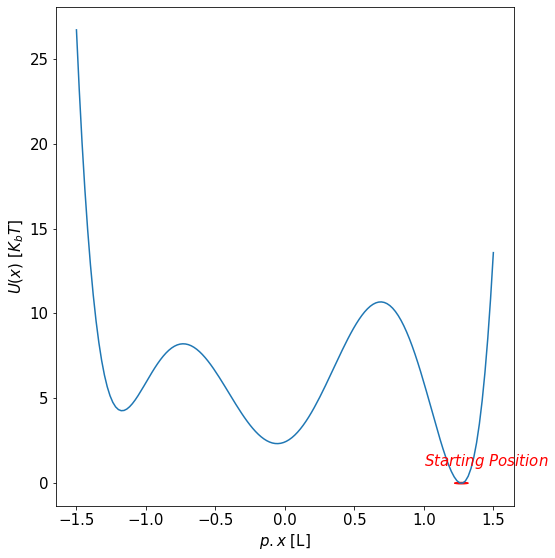

In [28]:
#-- 1d --#

x = np.linspace(-1.5,1.5,150)
y =  potential1d_function(x)
y-=np.min(y)
fig,ax = plt.subplots(figsize=(8,8)) 

ax.plot(x,y)
ax.set_xlabel(r"$p.x$ [L]")
ax.set_ylabel(r"$U(x)$ [$K_b T$]")

#-- highlight the starting point --#
ax.text(1,1,r'$Starting$ $Position$',color="red")
draw_circle = plt.Circle((1.27,0), 0.05, color="red")
ax.add_artist(draw_circle)

plt.tight_layout()

# Prepare input files for plumed

In [29]:
folder = "benchmark/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x FUNC="""+potential1d(),""" PERIODIC=NO
ene: BIASVALUE ARG=potential

# Bias 
opes: OPES_METAD ARG=p.x TEMP=1 PACE=500 FILE=KERNELS BIASFACTOR=2 BARRIER=8 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

# Print 
# STRIDE=100 so that the printed time is in 0.5 ps
PRINT FMT=%g STRIDE=100 FILE=COLVAR ARG=p.x,ene.bias,opes.*

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"],dim=1)
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")
#-- run plumed --#
execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data benchmark/
Completed: plumed ves_md_linearexpansion input


## Trajectory 

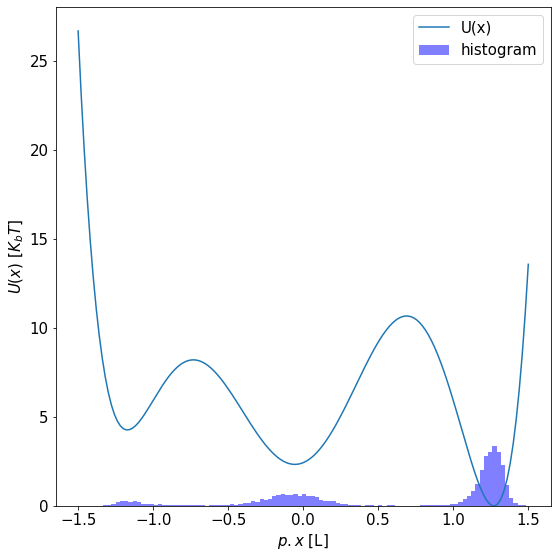

In [30]:
fig, ax = plt.subplots(figsize=(8,8))

x = load_dataframe(folder+"COLVAR").filter(regex="^p.x").values
ax.hist(x,bins=100,color="blue",alpha=0.5,label="Trajectory",density=True)

xx = np.linspace(-1.5,1.5,150)
y =  potential1d_function(xx)
y-=np.min(y)

ax.plot(xx,y)
ax.set_xlabel(r"$p.x$ [L]")
ax.set_ylabel(r"$U(x)$ [$K_b T$]")

ax.legend([r"U(x)","histogram"])

plt.tight_layout()

   time      p.x  ene.bias  opes.bias  opes.rct  opes.zed  opes.neff  \
0   0.0  1.27000  -2.43652       -8.0      -8.0       1.0    1.00067   
1   0.5  1.18288  -1.45379       -8.0      -8.0       1.0    1.00067   
2   1.0  1.07015   1.47399       -8.0      -8.0       1.0    1.00067   
3   1.5  1.32319  -1.93497       -8.0      -8.0       1.0    1.00067   
4   2.0  1.30230  -2.26033       -8.0      -8.0       1.0    1.00067   

   opes.nker  
0          0  
1          0  
2          0  
3          0  
4          0  


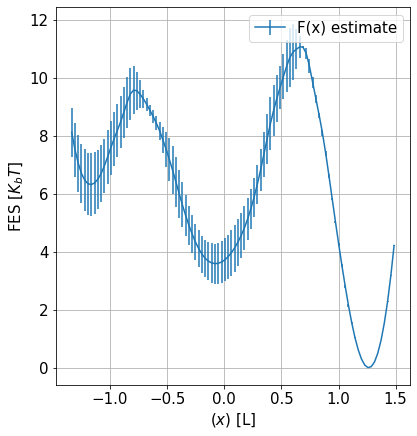

In [31]:
#-- estimation of Free Energy Surface --#
data = load_dataframe(folder+"COLVAR") 
print(data.head())
s = data["p.x"].to_numpy()
logweight = data["opes.bias"]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(6,6))

fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                    kbt=sim_parameters["temp"],
                                    blocks=sim_parameters["blocks"],
                                    bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                    plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(x)$ [L]")
ax.set_ylabel(r"FES [$K_b T$]")

plt.show()

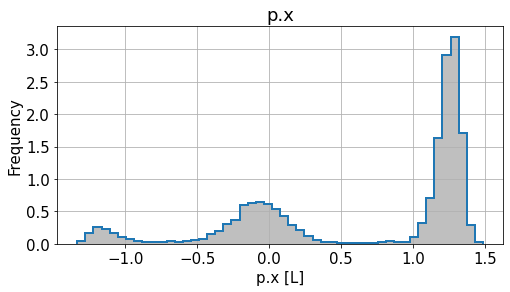

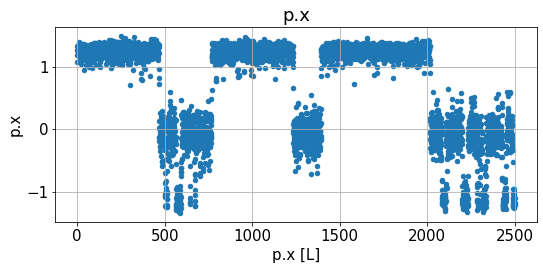

In [32]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values
desc = descriptors_names[0]
fig,ax = plt.subplots(1,1,figsize=(8,4),sharey=True)

data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
ax.set_xlabel(desc + " [L]")
ax.set_title(desc)

fig,ax = plt.subplots(1,1,figsize=(8,4),sharey=True)

data.plot.scatter(x="time",y="p.x",alpha=1,ax=ax,legend=False,grid=True)
ax.set_xlabel(desc + " [L]")
ax.set_title(desc)

plt.tight_layout()

# Training

In [33]:
data = load_dataframe(folder+"COLVAR")
size = len(data)
min_lag,max_lag = 0.5,5 
n = 1 # how many lag times between min and max lag
lags = np.linspace(min_lag,max_lag,n) #-- how many batches for the train and valid set of a single simulation
print(lags)
shuffle = False # if shuffle the data between batches
#-- train_datasets and valid_datasets list, it will be filled with new data every iteration
train_datasets = []
valid_datasets = []
# torch seed 
torch.manual_seed(21)

descriptors_names = data.filter(regex='^p').columns.values

#-- TRAINING PARAMETERS --#
n_output = 2
n_input = len(descriptors_names)
train_parameters = {
              'descriptors': '^p', # can change during simulation
              'nodes':[n_input,10,n_output],
              'activ_type': 'tanh',#'relu','selu','tanh'
              'lag_time':10, 
              'loss_type': 'sum',#'sum', 
              'n_eig': n_output,
              'trainsize':0.7, 
              'lrate':1e-3,
              'l2_reg':0,
              'num_epochs':500,
              'batchsize': -1, #---> è da fare sul train loder and valid loader
              'es_patience':10,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              }
#--------------------------------------#

print(train_parameters["nodes"])

# how many data in single batch, batchsize
n_train = int( size*train_parameters["trainsize"] )
n_valid = int( size*(1-train_parameters["trainsize"])-int(10*max_lag) )
print("training samples: ",n_train, "\t validation samples", n_valid)

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = data['time'].values
X = data[descriptors_names].values
print(X.shape)

logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
logweight /= sim_parameters["temp"]
logweight /= np.abs(min(logweight))
dt = t[1]-t[0]
tprime = dt * np.cumsum(np.exp(logweight))
tprime = t

[0.5]
[1, 10, 2]
training samples:  3500 	 validation samples 1450
(5001, 1)


In [34]:
# create time lagged dataset with different lag times
for lag in lags:
    #random split
    # TensorDataset (x_t,x_lag,w_t,w_lag)
    dataset = create_time_lagged_dataset(X,t=t,tprime=tprime,lag_time=lag,interval=[0,n_train+n_valid])
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_datasets.append(train_data)
    valid_datasets.append(valid_data)

train_loader = FastTensorDataLoader(train_datasets, batch_size=n_train,shuffle=shuffle)
valid_loader = FastTensorDataLoader(valid_datasets, batch_size=n_valid,shuffle=shuffle)

#-- TRAIN --#
# MODEL
model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'],gaussian_random_initialization=True)
model.to(device)
# OPTIMIZER (Adam)
opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])
# lrscheduler
#model.set_LRScheduler(opt,min_lr=5e-5)
model.set_optimizer(opt)
if valid_loader is not None:
    # EarlyStopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.0,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False) 
# TRAIN
model.fit(train_loader=train_loader,valid_loader=valid_loader,
    standardize_inputs=train_parameters['standardize_inputs'],
    standardize_outputs=train_parameters['standardize_outputs'],
    loss_type=train_parameters['loss_type'],
    n_eig=train_parameters['n_eig'],
    nepochs=train_parameters['num_epochs'],
    info=False, log_every=train_parameters['log_every'])
#-- move the model back to cpu for convenience --#
model.to('cpu')

INFO: Early stopping
Epoch Train Loss  Valid Loss  Eigenvalues             
25    -1.883      -1.913      0.984  0.895  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

In [35]:
#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

already exists
model saved
timescales:  [629.99426  90.35767]
eigenvalues:  [0.98425215 0.895233  ]


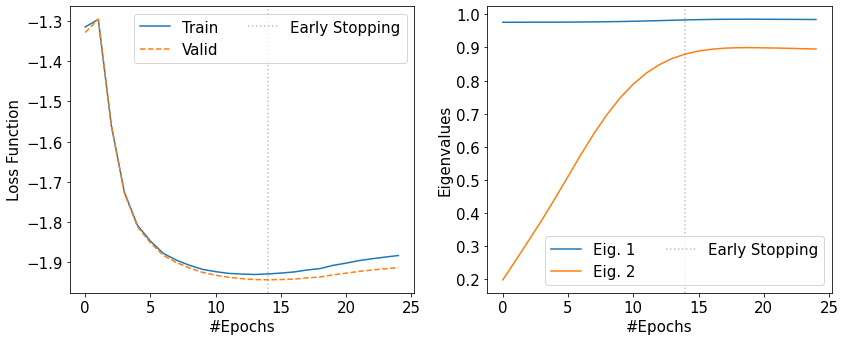

In [36]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [37]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
#data["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]

<AxesSubplot:ylabel='Frequency'>

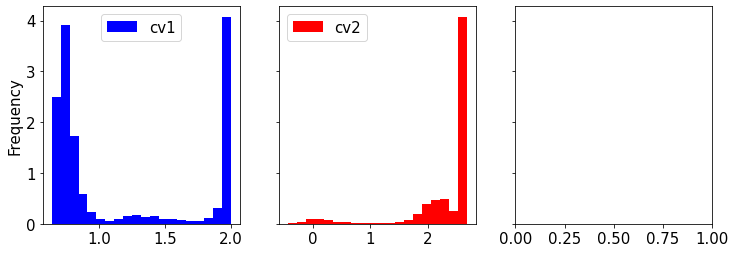

In [38]:
fig,axs = plt.subplots(1,3,figsize=(12,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
#data.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="g")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

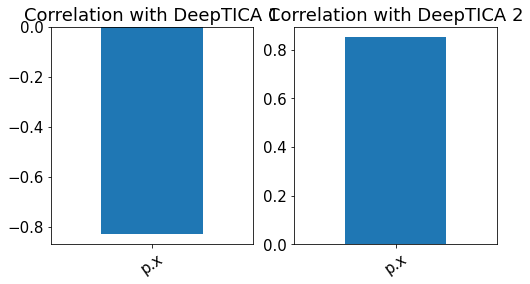

In [39]:
#fig,axs = plt.subplots(1,3,figsize=(16,4))
#for k,cv in enumerate(["cv1","cv2","cv3"]):
fig,axs = plt.subplots(1,2,figsize=(8,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


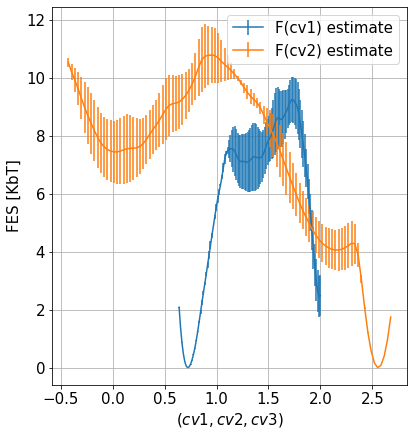

In [40]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
#logweight /= np.abs(min(logweight))
logweight /= sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate","F(cv3) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2,cv3)$")
ax.set_ylabel("FES [KbT]")

plt.show()

<AxesSubplot:xlabel='time', ylabel='p.x'>

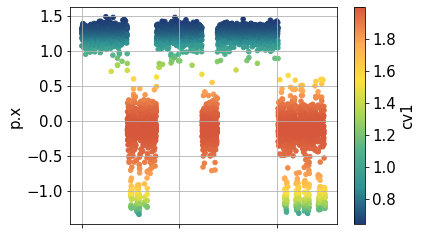

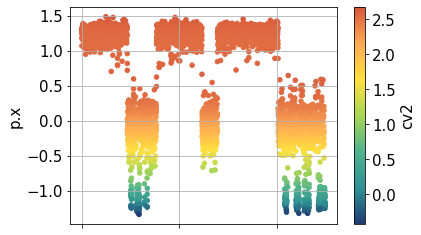

In [41]:
data.plot.scatter(x="time",y="p.x",c="cv1",alpha=1,legend=False,grid=True,cmap="fessa")
data.plot.scatter(x="time",y="p.x",c="cv2",alpha=1,legend=False,grid=True,cmap="fessa")
#data.plot.scatter(x="time",y="p.x",c="cv3",alpha=1,legend=False,grid=True,cmap="fessa")

### Isolines  

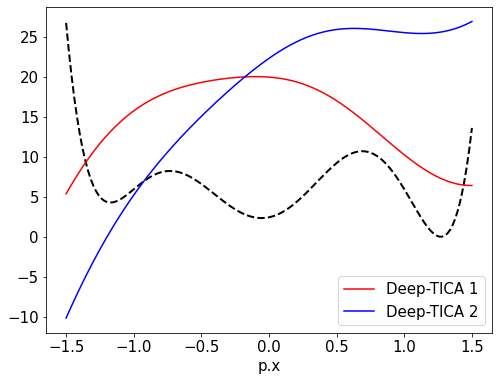

In [42]:
fig, ax = plt.subplots(figsize=(8,6))
xx = np.linspace(-1.5,1.5,150).reshape(150,1)
# potential energy
y =  potential1d_function(xx)
y-=np.min(y)
ax.plot(xx,y,linestyle="--",color="black",linewidth=2)
# first cv
y = np.transpose(model(torch.Tensor(xx)).detach().cpu().numpy())[0]*10#+1
ax.plot(xx,y,color="red",label="Deep-TICA 1")
# second cv
y = np.transpose(model(torch.Tensor(xx)).detach().cpu().numpy())[1]*10#+1
ax.plot(xx,y,color="blue",label="Deep-TICA 2")
# third cv
#y = np.transpose(model(torch.Tensor(xx)).detach().cpu().numpy())[2]*10#+1
#ax.plot(xx,y,color="green",label="Deep-TICA 3")

ax.set_xlabel("p.x")
ax.legend()

# TICA

In [43]:
# MODEL
tica = TICA_CV(n_features=X.shape[1])
tica.to(device)

t = data['time'].values
X = data[descriptors_names].values

In [44]:
# TRAIN
tica.fit(X, t, lag=min_lag)

#-- move the model back to cpu for convenience --# 
tica.to('cpu')

#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",tica.tica.evals_.detach().cpu().numpy())

eigenvalues:  [0.9760142]


In [45]:
data["cv1_tica"] = np.transpose(tica(torch.Tensor(X)).detach().cpu().numpy())[0]

<AxesSubplot:ylabel='Frequency'>

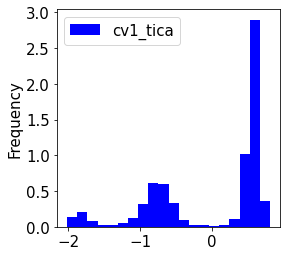

In [46]:
fig,axs = plt.subplots(1,1,figsize=(4,4),sharey=True)
data.plot.hist(y="cv1_tica",bins=20,ax=axs,density=True,color="b")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

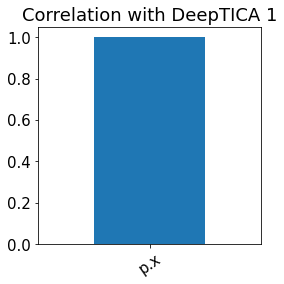

In [47]:
fig,axs = plt.subplots(1,1,figsize=(4,4))
for k,cv in enumerate(["cv1_tica"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs, rot=35)
    axs.set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


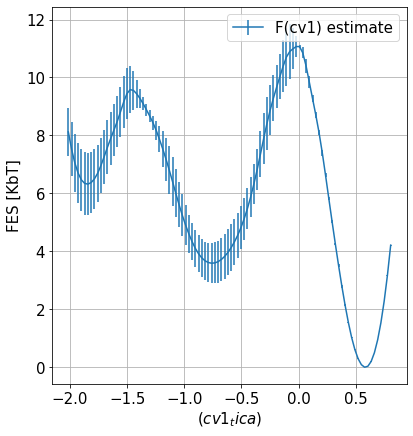

In [48]:
#-- estimation of Free Energy Surface --#
s = data["cv1_tica"].to_numpy()
logweight = data["opes.bias"].to_numpy()-max(data["opes.bias"].to_numpy())
#logweight /= np.abs(min(logweight))
logweight /= sim_parameters["temp"]


fig, ax = plt.subplots(figsize=(6,6))
for i in range(1):
    fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1_tica)$")
ax.set_ylabel("FES [KbT]")

plt.show()

<AxesSubplot:xlabel='time', ylabel='p.x'>

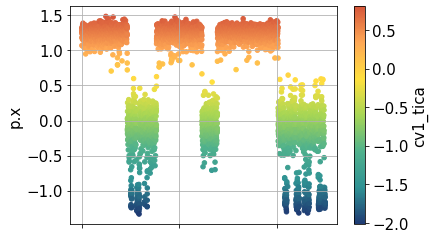

In [49]:
data.plot.scatter(x="time",y="p.x",c="cv1_tica",alpha=1,legend=False,grid=True,cmap="fessa")

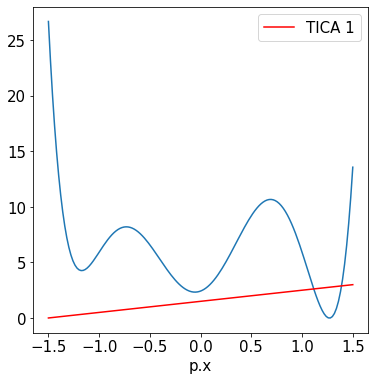

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
xx = np.linspace(-1.5,1.5,150).reshape(150,1)
# potential energy
y =  potential1d_function(xx)
y-=np.min(y)
ax.plot(xx,y)
# first cv
y = np.transpose(tica(torch.Tensor(xx)).detach().cpu().numpy())[0]
y -= np.min(y)
ax.plot(xx,y,color="red",label="TICA 1")

ax.set_xlabel("p.x")
ax.legend()